In [46]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [47]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read() #change if image captioning
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [48]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

#change if image captioning
# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [49]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [50]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        #self.rnn = nn.RNNCell(self.input_size, self.hidden_size) #change this to LSTM to GRU
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, 2)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = self.rnn(input,hidden)###### To be filled ######
        #print(input.shape)
        #print(hidden.shape)
        output,(h0,c0) = self.rnn(input,hidden)
        hidden = (h0,c0)
        #output =self.linear(hidden) ###### To be filled ######
        output = self.linear(output)
        #print(self.output.size)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return (torch.zeros(2, 1,self.hidden_size).to(device),torch.zeros(2, 1,self.hidden_size).to(device)) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): LSTM(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [51]:
output_list = []
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    #for t in range(seq_len):    # For each one in the input sequence.
   # print("target.shape")
    #print(target.shape)
    output, hidden = net(input, hidden)
    output = output.reshape(seq_len,-1)
    target = target.reshape(-1)
    output_list.append(output)
    #print("target.shape")
    #print(target.shape)
    #print("output.shape")
    #print(output.shape)
    
    loss += loss_func(output, target)

    loss.backward()             # Backward.  #comment if not update model
    opt.step()                  # Update the weights. #comment if not update model

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [52]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    #for t in range(len(init_seq) - 1):
    #output, hidden = net(init_input, hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input
    
    #print(output.shape)
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        
        output, hidden = net(input, hidden)
        
        # Get the current output and hidden state.
        #output_t = output[t]
        
        #output, hidden = net(input[t].reshape(, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char).to(device)

    return predicted_seq

#### Training Procedure

In [53]:
#when hidden_size is 512

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.026355836540460587
generated sequence: W ePh
Ny XiAtpo:lg, menng foCu s h ?yd :n; snnbes iOoiftuas s ewse,euade gsfiRfrsyrrtc hnsy .o;eko fy

iter:199/15000 loss:0.023397762328386307
generated sequence: W hanthigdy; tha hatendt ohafiatdaracetdissire
aOTan mode Arcy,,
her hasha may yitos Bnh
VIE
Ycaud o:

iter:299/15000 loss:0.021133705973625183
generated sequence: Weg ok, yasoose hek hafuse wamsmte vetb, doniyelart,
Hriips,

FIy norg vanTe: put;
ANvislt, Isy tou w

iter:399/15000 loss:0.019982835277915
generated sequence: Wp.

SRRI:
Beult at pour, wooors arnnrowit pet ad gow'nd
notht kide aes.
sry proy prat iwho pey haker

iter:499/15000 loss:0.019436515867710114
generated sequence: We
If iss, Celtore.
sen so'd fy
ney thacoadindn
Whe el thorey Woce 
I: Ry worg Fiofs?
Ciutr usa-ir of

iter:599/15000 loss:0.0187702439725399
generated sequence: Wanered you tte alcg arceum;
Thee I wurpid heuk, loirtite a who'd,
Are or cuilrald ranch thou tosne: 

iter:699/15000 loss:0.

#### Training Loss Curve

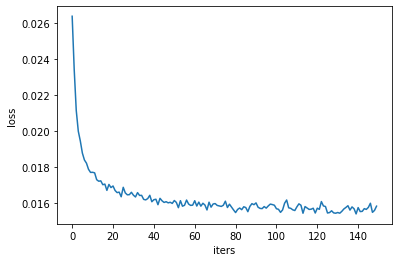

In [54]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [55]:
print(eval_step(net, predicted_len=600))

WAmnay Solder, unfave in of there ne,
Thy triker, wholes poun I take, the payn you maint deed to cly: I the my the sivent eathee this I graghans but candnt firle younce not not if I with cis I comitizeod Layhet dipvin be to hin him let what he onakead and onrent', not on am, at thontieken minn you fair,

GENUS:
Your nell gud loe'd fle a of will I hey hey your proly, all,
But it in thingnanrelf niult?

DETCUCESTA:
Lecpunt wicker the revet know forty, in flit bendigg all kant hence in before the to finten, honer,
Giit ni Excerfliebes I elten canshen thou my hat fumof not lingittinger do!

Jon hit


In [56]:
#I have two models
#retrain the same datasets on the new_train_method where update model is commented, compare the loss of model1 and model2, greater = bad 

In [57]:
#Adagrad as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adagrad(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.015239051543176174
generated sequence: WARENA:
Hous for Comecw his not and wast you sir.

SICAUGTIO:
I firth. The man upeks, errong
jot thy 

iter:199/15000 loss:0.015130793675780296
generated sequence: Whom herars wits weme beod, it awat be thove, I a wabt the ewhle thy you gremmise biynow is thell res

iter:299/15000 loss:0.014734026044607162
generated sequence: WARIO:
I ling that and dem a chy to lonk think ofpraveerroning wentw to grating, side, a herife

KING

iter:399/15000 loss:0.014743499457836151
generated sequence: WANTANPONMIET:
And so slect wandly gadyd my more: to itoorgious aft;
We my and if ding
Were your his 

iter:499/15000 loss:0.014926480129361153
generated sequence: WARIET:
Biry in I had
And base the, hotening you a-py hattading, the larreceneen and she in my bushet

iter:599/15000 loss:0.014723720028996468
generated sequence: WARD OLALIO:
For we thus for time!
Their but the, and to coak; besbst gor it strove!
By the whilve th

iter:699/15000 lo

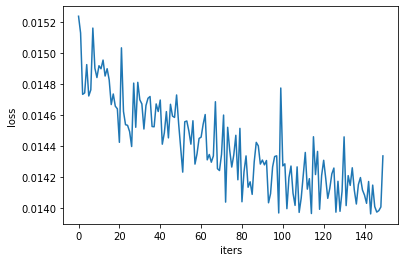

In [58]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [59]:
print(eval_step(net, predicted_len=600))

WARIEL:
To her forthing 'tissine: leaftly lech to't bey do crow
Grirt. Boop.
lord:
I'llrt pridiess
pure for the slawt I ol:
I with stratelt be woors kent's hears in houch, and coriout my gomle?
notents thou hath cinhurernown, hope, If Roln, your so to priclebear you is 
Work,
But, is Gead gelase recee, done, the pited let this you will orountrig.

MERRUS:
As then been Bolimeees and flohen, meant hink heugess Lurit all to you long sirst fursandise: what gome the nrade, you mere and thelt's any them, sprat theldounsfonjeive olscother, apppies hows.

TRANINA:
Foustert,
I wars, thou ofn reae,
To co


In [60]:
#AdamW as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.AdamW(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.014074134640395641
generated sequence: WARD IV
Whats,
I palt low, other spoth oud.

VIAS RALHINTIO:
As the sot togethy shall him paps think 

iter:199/15000 loss:0.014362786896526814
generated sequence: WARD:
We freae Turs tooce. Thou, waich well it cud,
I boukorr how weet, all his these
The greals, for

iter:299/15000 loss:0.014188213273882866
generated sequence: WARIO:
Beogs door.

MENENIUS:
Mopping the king thus Luceendon is hay.
Of wicy. That me Edwarch where,

iter:399/15000 loss:0.014079798012971878
generated sequence: WARTICHARD:
O, say I with one: face and into -

KING EDWARD IV:
O, are up falase
Unduds have! Teme li

iter:499/15000 loss:0.014079614542424679
generated sequence: Wrout whrt wonn.'
As wired the
Roors's up it seas:
nevice to 'hove, then the sithreed,
A jedelf,' I m

iter:599/15000 loss:0.013959519565105438
generated sequence: WARTISS OF YORK:
Bofes,
A mame,
Wert offing, and the knle the hold-prall buts of us, and make ster;
F

iter:699/15000 lo

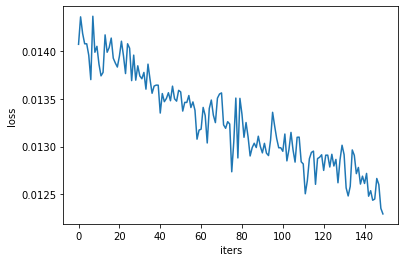

In [61]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [62]:
print(eval_step(net, predicted_len=600))

Whels, I speet bomious, and door all to some toid fall
That in Plopion this wroresman
To roghe the mind your helf,
eafal I for then mean:.

BENVOLIO:
How stand that I please is that honign cred him spepato!

LAR:
Sight tilen:
Which is had out. Wind that behorfmre? he dose it of the father of supity.

KING HENRY VI:
:
Far not of love me this?

DUKE VINCENTIO:
I jmisin, king a father bed. Anound lords
then come my lord, gpall griour hary natupes, pathee then;
Angelver wind for 'pons not us dastuk inlentleclable; here is that will new
Him as you, and the hand, withinerort love do,
Be chal meet, th


In [63]:
#Adamax as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adamax(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.012678065337240696
generated sequence: Whele as it loves that ; chers unton you be
For what we comes.
O, slaw the Marvish: that set you with

iter:199/15000 loss:0.01241257507354021
generated sequence: Witialdress sef:, but metward,
And what out ting of Vantacidon!
I desrovers confeefectment not happis

iter:299/15000 loss:0.012659024447202682
generated sequence: Wire sweet;
cy dewit bants one thinks Norfonfullio's too murt'd,
But I most wood doo'endless
And to t

iter:399/15000 loss:0.01251310110092163
generated sequence: What, suble comfert; it thank as parest are powers:
I will reput lay, and 'foresshing amow wribever l

iter:499/15000 loss:0.012208920903503895
generated sequence: Whourd though keepy anoch an atters of frish;
To mo'forte not answer and ado will te his Sip!

GLOUCE

iter:599/15000 loss:0.012250564061105251
generated sequence: Will,: be ptope much,
And as thou hass the is his than me having,
When I buckimish for fair moke of y

iter:699/15000 loss

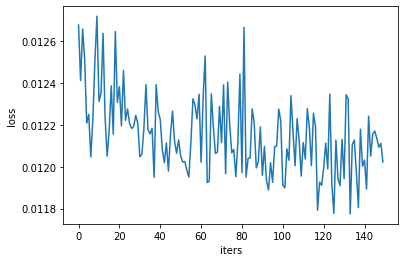

In [64]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [65]:
print(eval_step(net, predicted_len=600))

Wise, which or charp all'd real?

DUKE VINCENTIO:
This hate these days should shee, gre him.

KING RICHARD II:
May not dysast, I smess of thee any sit,
Than, you were else mean, tell Sich.
I strong, onier she flagues' you daublour'dion, as
your some with stand's corse dot eboughter
Is surpient:?
Saves to some,' his some monarses, 'tis a much gamuse: good they
care to hamp the must the anabes of poun.
Let would have made of store upon you, so; I could good shall heart;
Made is quietimes in from his his say!

DUKE VINCENTIO:
He must mabt worthy like envios oatenight
That I till to mines momion of


In [66]:
#RMSprop as opt

# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.RMSprop(net.parameters(), lr=0.05)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.06177368015050888
generated sequence: WhdesatoN rl,inTwt
irruoodN.gorsodod  o
rofa dwk
h nm iateagr
orittaos,nrdlidfleekenNlwagmsrark,hnp-.

iter:199/15000 loss:0.028157157823443413
generated sequence: Wd ngan a iag hnai aa aetdia ebymoaand iadcoavagaanngaaa;ac  nahaaae;;d at a;;aaa ada edntnn ha a a; 

iter:299/15000 loss:0.02807123400270939
generated sequence: WeKcd
t.ttit i .nv.hYrsuet ceygu Inrhtulydoua
lSdi

  
af .wmi il  
m  p
 it 
ihcnn  
uio i:;tl hNnsh

iter:399/15000 loss:0.029189858585596085
generated sequence: W: Lookkha'otaYI
 tdad CitncbormcoiFc  pi'i ereyoo;FRhaI   yot:ofruhac woh e;e roo' R thto
A'hSi;msso

iter:499/15000 loss:0.029080629348754883
generated sequence: W


Nli vma
  oorcovocrvvoiv
v
vaoo 
ouNo obwulgreoav, uu
yo oEoiheutp 
vlu oeu  poK arusoo lvoo oo  

iter:599/15000 loss:0.0282918568700552
generated sequence: WnhpNehadfohpo loh,pusttcriur irrfA pradup
uprponhIIu pnys ludosiOo r prluI a.truuupoTtlpnsaapuulpp n

iter:699/15000 loss:0

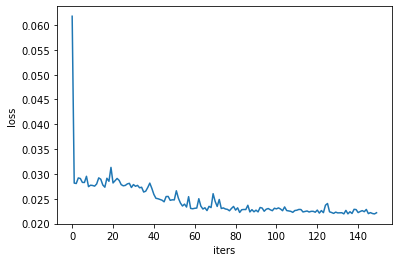

In [67]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()


In [68]:
print(eval_step(net, predicted_len=600))

WEHHCco sh bus aooocd ficcy eananvofhsuincourd tory tafe bout soult toonty,
Plureas. aotous e an,
Gor coetn or tour Ar I
Erd'urenot, tound do, ore on yus, mo, ece ur caay beares bee relor avorhe lavep ocl Gerrh kreml fir; if the co haurce reolioufaon eupgel yren i cou buf ue yo autt tor ipn souvor henls ofcoad nu woreose, or aurd youre roese toon bos yourouro ou forsen,, poun sor wonsarn the to ledy hosronorcocrros?  Dpworhen coue  d alotan   ein uroune one;
Adsouo thuuse ur re eraun ole., shaure fo'r foby o I wh or' as her aave icayn'evaauf anse er wu'atoncreeo.
Kos toyesroce hos veyn ouns'uns


In [17]:
# Draw the heatmap of training errors.
import seaborn as sns
def draw_heatmap1d(probability, char_list,title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(probability, annot=True, fmt='.3f', 
                     yticklabels=char_list)
    ax.collections[0].colorbar.set_label("accuracy")
    #ax.set( ylabel='%s'%(y_name))#'$\gamma$', ylabel='$C$')
    plt.title('visualization of %s' % (title))
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()


In [19]:
type(string.printable)

str

In [18]:

char_list = ["I","W","Y"] #sentence from validation file. Could be a selection from training file.
import numpy as np
draw_heatmap1d(np.array(nn.Softmax(np.array(output).reshape(1,-1))),char_list,'ss')
#each cell higher prob the better ->fits ground truth

ValueError: Must pass 2-d input

<Figure size 144x288 with 0 Axes>